# MultiForest optimization notebook

## MSc Ilmari: New EU Forest Strategy 2030; Central Finland

Above the code cells, there are short instructions how the users can modify the codes in the cells.<br>
If there are no instructions, no changes should be needed for the cell by default.

A detailed description is provided in the <b>README.md</b> (https://github.com/maeehart/MultiForestDemonstration#readme)

## Basic definitions

Simulated forest data (climate scenario and name); sample size of data 

In [70]:
RCP = "rcp45" # "rcp0" = no climate change, "rcp45" = Representative Concentration Pathway 4.5
filename = "sample_central_fin_"+RCP+".zip" # sample_central_fin_rcp0.zip

Specify policy scenario: 
* "EUFS" - EU Forest Strategy 2030

In [71]:
scenario = "refBAU"
#scenario = "refCCF" 

Name definition for saved output, rule: ..._scenario_RCP_extension

In [72]:
extension = "V4" # some additional info to the saved output 

## Read .py class

In [73]:
import wget
import os
import pandas as pd
import sys
import numpy as np

In [74]:
import multiFunctionalOptimization as MFO

In [75]:
from importlib import reload
reload(MFO)

<module 'multiFunctionalOptimization' from '/home/ubuntu/workspace/opt_ilmari/multiFunctionalOptimization.py'>

If no solver is specified, the open source solver CLP is used

In [76]:
mfo = MFO.MultiFunctionalOptimization(solver = 'CPLEX') 

'Using CPLEX'

## Read data

In [77]:
%%time
mfo.readData(filename,
             sampleRatio=1 #If no sample ratio given, the ratio is assumed to be 1.
            )                

CPU times: user 821 ms, sys: 502 ms, total: 1.32 s
Wall time: 1.32 s


In [78]:
id = mfo.data.id

def get_unique_numbers(numbers):

    list_of_unique_numbers = []

    unique_numbers = set(numbers)

    for number in unique_numbers:
        list_of_unique_numbers.append(number)

    return list_of_unique_numbers

id = get_unique_numbers(id)
id = pd.DataFrame(id)
id.to_csv("./id_1.csv")

### TEST - REMOVE Fertilization regimes

In [79]:
indexNames = mfo.data[(mfo.data[mfo.regimesEnu] == 'BAUwoT_m20_F') | 
                      (mfo.data[mfo.regimesEnu] == 'BAU_m5_F') | 
                      (mfo.data[mfo.regimesEnu] == 'BAU_F') |
                      (mfo.data[mfo.regimesEnu] == 'BAUwT_F') | 
                      (mfo.data[mfo.regimesEnu] == 'BAUwT_m5_F') ].index 
mfo.data.drop(indexNames, inplace = True)

In [80]:
mfo.data[mfo.regimesEnu].value_counts()

SA               71580
CCF_1            66760
BAUwoT_m20       66600
BAU_m5           66580
CCF_2            66520
BAU              66500
BAUwGTR          66500
BAUwoT           66500
BAU_5            66280
CCF_3            65760
BAU_15           64700
CCF_4            63760
BAU_30           56720
BAUwT_5          44420
BAUwT_m5         44420
BAUwT            44420
BAUwT_30         44420
BAUwT_GTR        44420
BAUwT_15         44420
BAUwT_15_B       28800
BAUwT_B          28800
BAUwT_GTR_B      28800
BAUwT_30_B       28800
BAUwT_5_B        28800
initial_state     3579
Name: regime, dtype: int64

In [81]:
# regimes for the BAU reference scenario

if scenario == 'refBAU':
    # MAYBE WE CAN TRY FIRST THIS 
    # if this already helps to screw down the peaks then we do not need the regimes with +5/-5
    #mfo.data = mfo.data[mfo.data['regime'].isin(['SA', 'BAU', 'BAUwoT', 'BAUwT', 'initial_state']) ]

    # If we still have peaks, we include for the BAU scenario also the +/- 5 regimes
    mfo.data = mfo.data[mfo.data['regime'].isin(['SA',
                                             'BAU', 'BAUwoT', 'BAUwT', 'BAU_m5', 'BAUwT_m5', 'BAU_5', 'BAUwT_5',
                                             'initial_state']) ]

    print("regimes for refBAU loaded")

regimes for refBAU loaded


In [82]:
# regimes for the CCF reference scenario
if scenario == 'refCCF':
    mfo.data = mfo.data[mfo.data['regime'].isin(['SA', 'CCF_3', 'CCF_4', "BAUwGTR", "BAUwT_GTR",'initial_state']) ] # 'CCF_1',
    
    print("objectives for refCCF loaded")

In [83]:
mfo.data[mfo.regimesEnu].value_counts()

SA               71580
BAU_m5           66580
BAU              66500
BAUwoT           66500
BAU_5            66280
BAUwT_5          44420
BAUwT_m5         44420
BAUwT            44420
initial_state     3579
Name: regime, dtype: int64

## Create some new variables in the data

Calculate total (per stand) values from relative values:
* "Relative to Area" = simulated indicator value relate to one hectar -> scaled to represented area of NFI plot <br>
* ("Relative to volume" = indicator relates to standing Volume -> scaled to the represented volume of the plot) <br>
* ("Absolute Value" = takes the inticator value as it is)

In [84]:
columnTypes = {
    'i_Vm3':(float,"Relative to Area"),
    'Harvested_V':(float,"Relative to Area"),
    'Harvested_V_log_under_bark':(float,"Relative to Area"), 
    'Harvested_V_pulp_under_bark':(float,"Relative to Area"),
    'Harvested_V_under_bark':(float,"Relative to Area"), 
    'Biomass':(float,"Relative to Area"),
    'ALL_MARKETED_MUSHROOMS':(float,"Relative to Area"), 
    'BILBERRY':(float,"Relative to Area"), 
    'COWBERRY':(float,"Relative to Area"),
    'HSI_MOOSE':(float,"Relative to Area"),
    'CAPERCAILLIE':(float,"Relative to Area"), 
    'HAZEL_GROUSE':(float,"Relative to Area"), 
    'V_total_deadwood':(float,"Relative to Area"), 
    'N_where_D_gt_40':(float,"Relative to Area"),
    'prc_V_deciduous':(float,"Relative to Area"),
    'CARBON_SINK':(float,"Relative to Area"), 
    'Recreation':(float,"Relative to Area"),
    'Scenic':(float,"Relative to Area")
}

In [85]:
mfo.calculateTotalValuesFromRelativeValues(columnTypes=columnTypes)

List the new created columns: <br>
* Total_... hectare value multiplied by represented area (or volume)

In [86]:
[name for name in mfo.data.columns if "Total_" in name and "Relative" not in name]

['Total_i_Vm3',
 'Total_Harvested_V',
 'Total_Harvested_V_log_under_bark',
 'Total_Harvested_V_pulp_under_bark',
 'Total_Harvested_V_under_bark',
 'Total_Biomass',
 'Total_ALL_MARKETED_MUSHROOMS',
 'Total_BILBERRY',
 'Total_COWBERRY',
 'Total_HSI_MOOSE',
 'Total_CAPERCAILLIE',
 'Total_HAZEL_GROUSE',
 'Total_V_total_deadwood',
 'Total_N_where_D_gt_40',
 'Total_prc_V_deciduous',
 'Total_CARBON_SINK',
 'Total_Recreation',
 'Total_Scenic']

## Create new column
1) Column indicating if regime is "CCF_3, CCF_4, BAUwGTR" (TRUE/FLASE) <br>
Important for FES Biodiversity, allowed regimes for conservation sites.

2) Column indicating if regime is "SA" (TRUE/FALSE)<br>
Important for FES Biodiversity, allowed regimes for statutory protection sites.

3) Column indicating if regime is "BAUwT_B, BAUwT_5_B, BAUwT_15_B, BAUwT_30_B, BAUwT_GTR_B" <br>
Important for FES Resillience, allowed regimes for climate change adaption.

In [87]:
regimeClassNames = {"regimeClass0name":"CCF",
                    "regimeClass1name":"SA",
                    "regimeClass2name":"Broadleave"}
regimeClassregimes = {"regimeClass0regimes":["CCF_3","CCF_4","BAUwGTR", "BAUwT_GTR"],
                      "regimeClass1regimes":["SA"],
                      "regimeClass2regimes":["BAUwT_B", "BAUwT_5_B", "BAUwT_15_B", "BAUwT_30_B", "BAUwT_GTR_B"]}

In [88]:
mfo.addRegimeClassifications(regimeClassNames = regimeClassNames,regimeClassregimes=regimeClassregimes)

### % of stands falling in strictly protected areas

In [89]:
list(mfo.data)

['id',
 'year',
 'regime',
 'V',
 'i_Vm3',
 'Harvested_V',
 'Harvested_V_log_under_bark',
 'Harvested_V_pulp_under_bark',
 'Harvested_V_under_bark',
 'MAIN_SP',
 'Age',
 'AGE_ba',
 'SC',
 'Biomass',
 'ALL_MARKETED_MUSHROOMS',
 'BILBERRY',
 'COWBERRY',
 'HSI_MOOSE',
 'CAPERCAILLIE',
 'HAZEL_GROUSE',
 'V_total_deadwood',
 'N_where_D_gt_40',
 'prc_V_deciduous',
 'PEAT',
 'clearcut',
 'CARBON_SINK',
 'CARBON_STORAGE_Update',
 'Recreation',
 'Scenic',
 'scenario',
 'represented_area_by_NFIplot',
 'region',
 'NUTS2_GL',
 'protection',
 'Total_i_Vm3',
 'Total_Harvested_V',
 'Total_Harvested_V_log_under_bark',
 'Total_Harvested_V_pulp_under_bark',
 'Total_Harvested_V_under_bark',
 'Total_Biomass',
 'Total_ALL_MARKETED_MUSHROOMS',
 'Total_BILBERRY',
 'Total_COWBERRY',
 'Total_HSI_MOOSE',
 'Total_CAPERCAILLIE',
 'Total_HAZEL_GROUSE',
 'Total_V_total_deadwood',
 'Total_N_where_D_gt_40',
 'Total_prc_V_deciduous',
 'Total_CARBON_SINK',
 'Total_Recreation',
 'Total_Scenic',
 'CCF_forests',
 'SA_fore

In [90]:
# Number of all stands
# len(mfo.data["id"].unique())
standid = mfo.data.drop_duplicates(['id'])
len(standid)

3579

In [91]:
len(standid[(standid["protection"] == "strict")]) / len(standid) * 100

2.7102542609667504

### % of stands only with set aside (incl. strictly protected & other unmanaged)

In [92]:
managed = mfo.data[(mfo.data["regime"] != "SA") & (mfo.data["regime"] != "initial_state")]
not_managed = mfo.data[(mfo.data["regime"] == "SA") ]

( len(not_managed["id"].unique()) - len(managed["id"].unique()) ) / len(not_managed["id"].unique()) * 100

6.007264599050014

### Define primary/old forest for additional protection

In [93]:
mfo.data['MAIN_SP'].unique()

array([2, 0, 1, 4, 3, 6, 9, 5, 8])

In [94]:
# value>1 Pinus sylvestris
# value>2 Picea abies
# value>3 Betula pendula
# value>4 Betula pubescens
# value>5 Populus tremula
# value>6 Alnus incana
# value>7 Alnus glutinosa<
# value>8 other coniferous tree species
# value>9 other decidious tree species

list_conifer = [1,2,8]
list_broadleave = [3,4,5,6,7,9]

In [95]:
# column indicating if old forest AND if regime SA
mfo.data['Old_forests'] = np.where(
    (mfo.data['AGE_ba'] >= 90) & (mfo.data['MAIN_SP'].isin(list_conifer) & (mfo.data['SA_forests'] == True) & (mfo.data['protection'] != "strict")) |
    (mfo.data['AGE_ba'] >= 90) & (mfo.data['MAIN_SP'].isin(list_broadleave) & (mfo.data['SA_forests'] == True) & (mfo.data['protection'] != "strict"))
        , True, False
)

## Define initial value
1) Define initial values, recognized by the regime "initial_state", which only occurs at the first year (here 2016)

2) Create new variables that describe the <b>relative change to initial situation (start year) "Relative_"</b>:

In [96]:
mfo.finalizeData(initialRegime="initial_state")

New variables created:

In [97]:
[name for name in mfo.data.columns if "Relative_" in name]

['Relative_V',
 'Relative_Age',
 'Relative_AGE_ba',
 'Relative_ALL_MARKETED_MUSHROOMS',
 'Relative_BILBERRY',
 'Relative_COWBERRY',
 'Relative_HSI_MOOSE',
 'Relative_CAPERCAILLIE',
 'Relative_HAZEL_GROUSE',
 'Relative_V_total_deadwood',
 'Relative_N_where_D_gt_40',
 'Relative_prc_V_deciduous',
 'Relative_CARBON_STORAGE_Update',
 'Relative_Recreation',
 'Relative_Scenic',
 'Relative_Total_ALL_MARKETED_MUSHROOMS',
 'Relative_Total_BILBERRY',
 'Relative_Total_COWBERRY',
 'Relative_Total_HSI_MOOSE',
 'Relative_Total_CAPERCAILLIE',
 'Relative_Total_HAZEL_GROUSE',
 'Relative_Total_V_total_deadwood',
 'Relative_Total_N_where_D_gt_40',
 'Relative_Total_prc_V_deciduous',
 'Relative_Total_Recreation',
 'Relative_Total_Scenic']

In [98]:
mfo.data.head()

V  i_Vm3  Harvested_V  Harvested_V_log_under_bark  \
id       year regime                                                            
99011012 2021 BAU      113.94  10.59          0.0                         0.0   
              BAU_5    113.94  10.59          0.0                         0.0   
              BAU_m5   113.94  10.59          0.0                         0.0   
              BAUwT    113.94  10.59          0.0                         0.0   
              BAUwT_5  113.94  10.59          0.0                         0.0   

                       Harvested_V_pulp_under_bark  Harvested_V_under_bark  \
id       year regime                                                         
99011012 2021 BAU                              0.0                     0.0   
              BAU_5                            0.0                     0.0   
              BAU_m5                           0.0                     0.0   
              BAUwT                            0.0                     0.0   
              BAUwT_5                          0.0                     0.0   

                       MAIN_SP   Age  AGE_ba  SC  ...  \
id       year regime                              ...   
99011012 2021 BAU            3  24.0   29.26   2  ...   
              BAU_5          3  24.0   29.26   2  ...   
              BAU_m5         3  24.0   29.26   2  ...   
              BAUwT          3  24.0   29.26   2  ...   
              BAUwT_5        3  24.0   29.26   2  ...   

                       Relative_Total_BILBERRY  Relative_Total_COWBERRY  \
id       year regime                                                      
99011012 2021 BAU                     0.000124                 0.000225   
              BAU_5                   0.000124                 0.000225   
              BAU_m5                  0.000124                 0.000225   
              BAUwT                   0.000124                 0.000225   
              BAUwT_5                 0.000124                 0.000225   

                       Relative_Total_HSI_MOOSE  Relative_Total_CAPERCAILLIE  \
id       year regime                                                           
99011012 2021 BAU                           0.0                          0.0   
              BAU_5                         0.0                          0.0   
              BAU_m5                        0.0                          0.0   
              BAUwT                         0.0                          0.0   
              BAUwT_5                       0.0                          0.0   

                       Relative_Total_HAZEL_GROUSE  \
id       year regime                                 
99011012 2021 BAU                              0.0   
              BAU_5                            0.0   
              BAU_m5                           0.0   
              BAUwT                            0.0   
              BAUwT_5                          0.0   

                       Relative_Total_V_total_deadwood  \
id       year regime                                     
99011012 2021 BAU                             0.000308   
              BAU_5                           0.000308   
              BAU_m5                          0.000308   
              BAUwT                           0.000308   
              BAUwT_5                         0.000308   

                       Relative_Total_N_where_D_gt_40  \
id       year regime                                    
99011012 2021 BAU                                 0.0   
              BAU_5                               0.0   
              BAU_m5                              0.0   
              BAUwT                               0.0   
              BAUwT_5                             0.0   

                       Relative_Total_prc_V_deciduous  \
id       year regime                                    
99011012 2021 BAU                            0.000776   
              BAU_5                          0.000776   
            

In [99]:
mfo.initialData.head()

,,,V,i_Vm3,Harvested_V,Harvested_V_log_under_bark,Harvested_V_pulp_under_bark,Harvested_V_under_bark,MAIN_SP,Age,AGE_ba,SC,...,Total_V_total_deadwood,Total_N_where_D_gt_40,Total_prc_V_deciduous,Total_CARBON_SINK,Total_Recreation,Total_Scenic,CCF_forests,SA_forests,Broadleave_forests,Old_forests
id,year,regime,,,,,,,,,,,,,,,,,,,,,
99011012,2016,initial_state,64.83,0.0,0.0,0.0,0.0,0.0,3,16.0,26.86,2,...,1508.60,0.0,26996.0,0.0,1915.525,1424.833,False,False,False,False
99011013,2016,initial_state,27.12,0.0,0.0,0.0,0.0,0.0,2,15.0,14.92,2,...,1508.60,0.0,4764.0,0.0,1818.260,1428.406,False,False,False,False
99011014,2016,initial_state,374.02,0.0,0.0,0.0,0.0,0.0,2,80.0,79.48,1,...,1496.69,0.0,1191.0,0.0,2503.879,2317.289,False,False,False,False
99011015,2016,initial_state,4.19,0.0,0.0,0.0,0.0,0.0,2,11.0,9.42,2,...,1496.69,0.0,12307.0,0.0,1565.371,1272.385,False,False,False,False
99011016,2016,initial_state,141.85,0.0,0.0,0.0,0.0,0.0,1,89.0,71.71,4,...,1417.29,0.0,5161.0,0.0,2374.854,2432.816,False,False,False,False


## Define the optimization problem for policy scenarios
See README.md for details.

<b>Objective format:</b>

Unique_key :[Long human readable name, column name in data, max/min objective, year wise aggregation, stand wise aggregation (, target year )]

1) "Unique_key" : [ (2) "Long human readable name", (3) "column name", (4) "max/min objective", (5) "year wise aggregation", (6) "stand wise aggregation" (, (7) target year ) ]

<b>Options for "objective":</b> "max"imise or "min"imise it <br>
<b>year wise aggregation:</b> "min" (minimum value), "average", "firstYear", "targetYearWithSlope","targetYear","lastYear" <br>
<b>stand wise aggregation:</b> "sum", "areaWeightedAverage", "areaWeightedSum" <br>
<b>targe yeart:</b> any year except the first one

### EUFS - EU Forest Strategy 2030 - V1

In [100]:
if scenario == 'EUFS':
    
    biodiversity = {
    # Conservation regimes - overall target of 10%
    "Ratio_SA_forests": ["Ratio of protected areas (%, SA forests)",
                         "SA_forests","max","firstYear","areaWeightedAverage"],    
        
    # Additional strictly protected areas (on top of minimum possible for Ratio of protected areas)
    "Ratio_strictly_protected": ["Ratio of additional strictly protected forest (%, set aside)",
                          "Old_forests","max","firstYear","areaWeightedAverage"],  
        
    # Protection regimes "effective management" - target of 20%
    "Ratio_protection_regimes": ["Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)",
                          "CCF_forests","max","firstYear","areaWeightedAverage"],
        
    # Deadwood - maximise the deadwood in the protection regimes (could also be Age, or large living trees?)
    #"Total_Deadwood_V": ["Maximise deadwood in protected areas (m3)", 
    #                     "V_total_deadwood","max","min","subsetSum","CCF_forests"],
        
    # Large trees - maximise the large trees in the protection regimes
    "Total_Large_trees": ["Maximise large trees in protected areas (m3)", 
                          "Total_N_where_D_gt_40","max","min","subsetSum","CCF_forests"],
    
    # Deadwood - maximise over all forest
    "Avg_Deadwood_V": ["Average deadwood volume (m3/ha)", 
                       "V_total_deadwood","max","min","areaWeightedAverage"] , 

    # Deciduous trees (% of volume)
    "Avg_prc_V_deciduous":  ["Share of deciduous trees (% of standing volume)", 
                             "prc_V_deciduous","max", "min","areaWeightedAverage"]  
    }
    
    wood_production = { 
    # Harvested roundwood
    "Avg_Harvested_V" : ["Average harvested timber volume (log & pulp) (m3/ha, evenflow)",
                             "Harvested_V",
                             "max","min","areaWeightedAverage"] #,
    
    # Increment
    #"Avg_i_Vm3": ["Average timber volume increment(m3/ha)",
    #                  "i_Vm3","max","min","areaWeightedAverage"]
    }
    
    bioenergy = { 
    # Harvested biomass
    "Avg_Biomass": ["Average harvested biomass volume (m3/ha, evenflow)",
                    "Biomass", "max","min","areaWeightedAverage"]
    }
    
    climate_regulation = {
    # Carbon sink
    "Total_CARBON_SINK": ["Sequestration in carbon dioxide (t CO2)",
                          "CARBON_SINK","max","min","areaWeightedSum"] 
    }
    
    nonwood = {
    # Recreation index 
    "Total_Recreation" : ["Recreation index (max minimum over yrs)",
                          "Recreation","max","min","areaWeightedSum"],
        
    # Scenic index - maximise
    "Total_Scenic" : ["Scenic index (max minimum over yrs)",
                      "Scenic", "max","min","areaWeightedSum"],   
        
    # Bilberry - no decline, maximise it
    "Avg_BILBERRY": ["Average Bilberry yield (kg/ha)",
                     "BILBERRY","max","min","areaWeightedAverage"],
    
    # Cowberry - no decline, maximise it
    "Avg_COWBERRY": ["Average Cowberry yield (kg/ha)",
                     "COWBERRY","max","min","areaWeightedAverage"],
    
    # Mushrooms - no decline, maximise it
    "Avg_ALL_MARKETED_MUSHROOMS": ["Average mushroom yield (kg/ha)",
                                   "ALL_MARKETED_MUSHROOMS","max","min","areaWeightedAverage"]
    
    }

    objectives = {
              **biodiversity,
              **wood_production,
              **bioenergy,
              **climate_regulation ,
              **nonwood,
    }
    
    print("objectives for EUFS loaded")

In [101]:
if scenario == 'refCCF' or scenario == 'refBAU':
    
    wood_production = { 
    # included to smooth the peaks down
    "upper_Harvested_V" : ["Upper total harvest treshold (log & pulp) (m3, evenflow)",
                        "Harvested_V",
                         "min","max","areaWeightedSum"] ,
        
    # aiming to maximise the minimum and stay above the historic lowest value 
    # table 5.4; https://stat.luke.fi/sites/default/files/suomen_metsatilastot_2021_verkko.pdf
    # 5.531 million m3 for log + pulp 
    "lower_Harvested_V" : ["Lower total harvest treshold (log & pulp) (m3, evenflow)",
                         "Harvested_V",
                         "max","min","areaWeightedSum"] #,
              
    ## Harvested roundwood
    #"Avg_Harvested_V" : ["Average harvested timber volume (log & pulp) (m3/ha, evenflow)",
    #                     "Harvested_V",
    #                     "max","min","areaWeightedAverage"] ,
    #
    # Increment
    #"Avg_i_Vm3": ["Average timber volume increment(m3/ha)",
    #              "i_Vm3","max","min","areaWeightedAverage"]    
    }
    objectives = {
              **wood_production
    }
    
    print("objectives for REF loaded")

objectives for REF loaded


In [102]:
len(objectives)

2

In [103]:
objectives.keys()

dict_keys(['upper_Harvested_V', 'lower_Harvested_V'])

In [104]:
mfo.data.columns

Index(['V', 'i_Vm3', 'Harvested_V', 'Harvested_V_log_under_bark',
       'Harvested_V_pulp_under_bark', 'Harvested_V_under_bark', 'MAIN_SP',
       'Age', 'AGE_ba', 'SC', 'Biomass', 'ALL_MARKETED_MUSHROOMS', 'BILBERRY',
       'COWBERRY', 'HSI_MOOSE', 'CAPERCAILLIE', 'HAZEL_GROUSE',
       'V_total_deadwood', 'N_where_D_gt_40', 'prc_V_deciduous', 'PEAT',
       'clearcut', 'CARBON_SINK', 'CARBON_STORAGE_Update', 'Recreation',
       'Scenic', 'scenario', 'represented_area_by_NFIplot', 'region',
       'NUTS2_GL', 'protection', 'Total_i_Vm3', 'Total_Harvested_V',
       'Total_Harvested_V_log_under_bark', 'Total_Harvested_V_pulp_under_bark',
       'Total_Harvested_V_under_bark', 'Total_Biomass',
       'Total_ALL_MARKETED_MUSHROOMS', 'Total_BILBERRY', 'Total_COWBERRY',
       'Total_HSI_MOOSE', 'Total_CAPERCAILLIE', 'Total_HAZEL_GROUSE',
       'Total_V_total_deadwood', 'Total_N_where_D_gt_40',
       'Total_prc_V_deciduous', 'Total_CARBON_SINK', 'Total_Recreation',
       'Total_Sceni

In [105]:
[(col,mfo.data.dtypes[col]) for col in mfo.data.columns if "prc" in col]

[('prc_V_deciduous', dtype('float64')),
 ('Total_prc_V_deciduous', dtype('float64')),
 ('Relative_prc_V_deciduous', dtype('float64')),
 ('Relative_Total_prc_V_deciduous', dtype('float64'))]

## Define initial values NOT available in data, but needed for objective

Examples are increment, harvests, biomass and carbon sink. They are required for the "targetYearWithSlope" objective, but values only occur after the first simulation period. National values are taken from the policy or forest statistics. 

<b>For the EU Forest Strategy scenario this might not be required.</b> 

In [106]:
#initialValues = {"Total_Harvested_V": 5.5*10**6}      # coming from national statistic 

In [107]:
#mfo.defineObjectives(objectives,initialValues = initialValues)
mfo.defineObjectives(objectives)

'Defining objectives'

'Aggregating stand wise'

100%|██████████| 2/2 [00:11<00:00,  5.92s/it]


'Aggregating year wise'

100%|██████████| 2/2 [00:00<00:00, 1800.90it/s]


'Objectives added'

## Define enabled constraints

<b>For the EU Forest Strategy scenario this might not be required. </b> OR it can be a different enabled constraint - maybe related to the protection targets. Let´s see how the policy table looks ... 

In [108]:
CCFregimes = [regime for regime in mfo.regimes if "CCF" in regime] + ["SA"]

In [109]:
CCFregimes

['SA']

Constraint format:
- Shortname: "constraint type","allowed regimes","human readable name",(regimes),"column in data")

In [110]:
constraintTypes = {"CCFonPeat":["Allowed regimes","Only CCF on peat lands",CCFregimes,"PEAT"]}

In [111]:
mfo.defineConstraints(constraintTypes)

## Calculate objective ranges
The ideal and anti-ideal solution for the individual objective functions.

In [112]:
%%time
mfo.calculateObjectiveRanges(debug=True)

'Calculating objective ranges'

  0%|          | 0/2 [00:00<?, ?it/s]

'Optimizing for Upper total harvest treshold (log & pulp) (m3, evenflow)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'Upper total harvest treshold (log & pulp) (m3, evenflow)'

0.0

'Lower total harvest treshold (log & pulp) (m3, evenflow)'

0.0

 50%|█████     | 1/2 [00:00<00:00,  3.68it/s]

'Optimizing for Lower total harvest treshold (log & pulp) (m3, evenflow)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'Upper total harvest treshold (log & pulp) (m3, evenflow)'

9810522.462784996

'Lower total harvest treshold (log & pulp) (m3, evenflow)'

6838967.63559842

100%|██████████| 2/2 [00:01<00:00,  1.77it/s]
CPU times: user 2.59 s, sys: 354 ms, total: 2.94 s
Wall time: 1.14 s


In [113]:
mfo.objectiveRanges

{'upper_Harvested_V': (0.0, 9810522.462784996),
 'lower_Harvested_V': (0.0, 6838967.63559842)}

## Show GUI

* If "Enabled constraints" should be considered, start with ticking box "only CCF ..." and push "Change constraints"
* Epsilon constraints are only considered if sliders are moved and button "Set epsilon constraints" is pushed
* By pushing "OPTIMIZE" an optimal solution under the given constraints and reference points is searched

In [133]:
mfo.showGUI(debug=True)

interactive(children=(FloatSlider(value=9810522.462784996, description='Upper total harvest treshold (log & pu…

interactive(children=(FloatSlider(value=4905261.231392498, description='Upper total harvest treshold (log & pu…

interactive(children=(Checkbox(value=False, description='Only CCF on peat lands'), Button(description='Change …

Button(description='Print solution', style=ButtonStyle())

## Visualization of optimal solution

In [134]:
regimeAmounts = {regime:0 for regime in mfo.regimes}
for key in mfo.regimesDecision.keys():
    regimeAmounts[key[1]] +=mfo.regimesDecision[key].solution_value()*mfo.standAreas.loc[key[0],"represented_area_by_NFIplot"]/mfo.standAreas["represented_area_by_NFIplot"].sum()

In [135]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [136]:
#[val for val in regimeAmounts.values()]

<IPython.core.display.Javascript object>


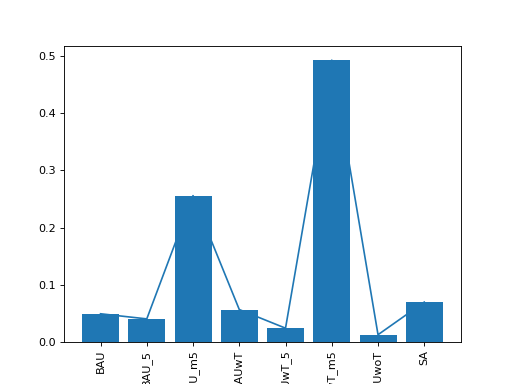

In [137]:
plt.plot([key for key in regimeAmounts.keys()],[val for val in regimeAmounts.values()])

In [138]:
plt.bar(range(len(regimeAmounts)), list(regimeAmounts.values()), align='center')
plt.xticks(range(len(regimeAmounts)), list(regimeAmounts.keys()),rotation="vertical")

([<matplotlib.axis.XTick at 0x7f53c1e3bc70>,
 [Text(0, 0, 'BAU'),
  Text(1, 0, 'BAU_5'),
  Text(2, 0, 'BAU_m5'),
  Text(3, 0, 'BAUwT'),
  Text(4, 0, 'BAUwT_5'),
  Text(5, 0, 'BAUwT_m5'),
  Text(6, 0, 'BAUwoT'),
  Text(7, 0, 'SA')])

## Export data as csv

- <b>Solution_alldata</b> contains the optimal regime per stand AND the timely development of indicator values plus all other input columns (represented_are_by_NFIplot, region, NUTS2)
- <b>Solution</b> contains only the selected optimal regime and its share (if multiple regimes per stand are selected)


In [139]:
try:
    os.mkdir("results")
except FileExistsError:
    pass
b = []
c = []
for key in mfo.regimesDecision.keys():
    if mfo.regimesDecision[key].solution_value() > 0:
        b = b+ [(key[0],x*5+2016, key[1]) for x in range(0,21)]
        c = c+ [(key[0],key[1],mfo.regimesDecision[key].solution_value())]
data2b = mfo.data.iloc[mfo.data.index.isin(b)]
data2b.to_csv("./results/solutionAlldata_"+scenario+"_"+RCP+"_"+extension+".csv")
c1 = pd.DataFrame(c)
c1.to_csv("./results/solution_"+scenario+"_"+RCP+"_"+extension+".csv")

## Export objective ranges 

Save as json file

In [140]:
import json
mfo.objectiveRanges

with open('./results/objectiveRanges_'+scenario+'_'+RCP+'_'+extension+'.json', 'w') as json_file:
  json.dump(mfo.objectiveRanges, json_file)

Save as CSV.

In [141]:
df = pd.read_json('./results/objectiveRanges_'+scenario+'_'+RCP+'_'+extension+'.json')

df.to_csv('./results/objectiveRanges_'+scenario+'_'+RCP+'_'+extension+'.csv')

## Export objective values
The optimal solution for each objective.

In [142]:
with open("./results/objectiveValues_"+scenario+'_'+RCP+'_'+extension+".csv","w") as file: 
    delim = "" 
    for objName in mfo.objectiveTypes.keys(): 
        file.write(delim+objName) 
        delim = "," 
    file.write("\n") 
    delim = "" 
    for objName in mfo.objectiveTypes.keys(): 
        file.write(delim+str(mfo.objective[objName].solution_value())) 
        delim = "," 
    file.write("\n")